# Importing Libraries

In [1]:
import torch 
from torch import nn 
from torch.optim import Adam 
import torchvision.transforms as transforms 
from torch.utils.data import Dataset, DataLoader 
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt 
from PIL import Image
import pandas as pd 
import numpy as np
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
print("Device available: ", device)

Device available:  cuda


# Loading Data

In [3]:
image_path = [] 
labels = []     

for split in os.listdir("afhq"):  # 'train', 'val'
    for label in os.listdir(f"afhq/{split}"):  # 'cat', 'dog', 'wild'
        for image in os.listdir(f"afhq/{split}/{label}"):  # loop through image files
            labels.append(label)
            image_path.append(f"afhq/{split}/{label}/{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns=['image_paths', 'labels'])   #the two lists are now coverted into a dtaframe

data_df.head()

,image_paths,labels
0,afhq/train/cat/flickr_cat_000002.jpg,cat
1,afhq/train/cat/flickr_cat_000003.jpg,cat
2,afhq/train/cat/flickr_cat_000004.jpg,cat
3,afhq/train/cat/flickr_cat_000005.jpg,cat
4,afhq/train/cat/flickr_cat_000006.jpg,cat


# Data Split

In [ ]:
train=data_df.sample(frac=0.7,random_state=7) 
test=data_df.drop(train.index) 

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index)    

# Preprocessing

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

LabelEncoder()

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

# Custom Dataset Class

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image)

        return image, label

#### Dataset Objects

In [8]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# Hyperparameters

In [9]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 5

# Data Loader

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# CNN Model

In [11]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) 

#### Model Summary

In [12]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

# Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

# Training and Validation

In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.long().to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100

    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = (correct_val / total_val) * 100

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/5, Train Loss: 0.5563, Train Accuracy: 76.67%, Val Loss: 0.3211, Val Accuracy: 87.40%
Epoch 2/5, Train Loss: 0.2664, Train Accuracy: 90.42%, Val Loss: 0.2349, Val Accuracy: 91.20%
Epoch 3/5, Train Loss: 0.1769, Train Accuracy: 93.67%, Val Loss: 0.1623, Val Accuracy: 94.71%
Epoch 4/5, Train Loss: 0.1208, Train Accuracy: 95.74%, Val Loss: 0.1490, Val Accuracy: 94.83%
Epoch 5/5, Train Loss: 0.0911, Train Accuracy: 96.64%, Val Loss: 0.1128, Val Accuracy: 96.16%


# Visualization

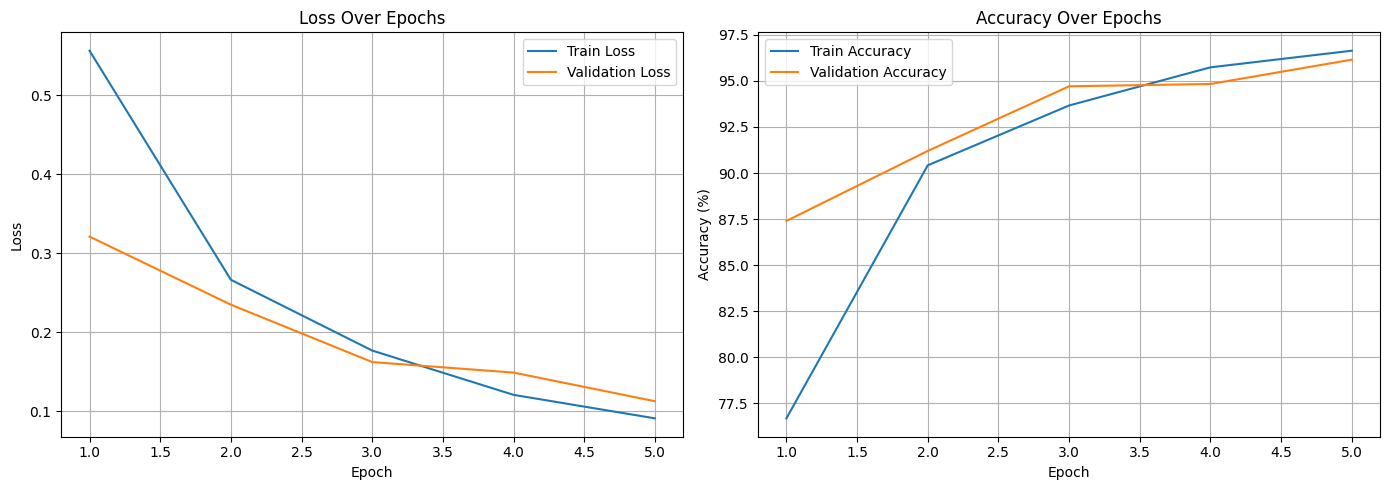

In [15]:
epochs = range(1, len(train_losses) + 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(epochs, train_losses, label='Train Loss')
axs[0].plot(epochs, val_losses, label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs, train_accuracies, label='Train Accuracy')
axs[1].plot(epochs, val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Model Evaluation

In [16]:
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.long().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = (correct / total) * 100

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.1108, Test Accuracy: 95.95%
